In [ ]:
# %pip install numpy pandas matplotlib opencv-python opencv-python-headless
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as lxml


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1. Read the labels of the image

In [8]:
df = pd.read_csv("labels.csv")
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../labelling/output/Cars213.xml,150,233,160,194
1,../labelling/output/Cars207.xml,254,372,229,264
2,../labelling/output/Cars398.xml,72,196,139,222
3,../labelling/output/Cars367.xml,224,382,161,222
4,../labelling/output/N107.xml,217,343,185,279


### 2. Extracting image path and add to dataframe

In [9]:
import os
def getImageName(xml_file_path):
  image_name = lxml.parse(xml_file_path).getroot().find("filename").text
  return os.path.join("../labelling/images/",image_name);
df["image_path"] = df["filepath"].apply(getImageName);
df.head()

,filepath,xmin,xmax,ymin,ymax,image_path
0,../labelling/output/Cars213.xml,150,233,160,194,../labelling/images/Cars213.png
1,../labelling/output/Cars207.xml,254,372,229,264,../labelling/images/Cars207.png
2,../labelling/output/Cars398.xml,72,196,139,222,../labelling/images/Cars398.png
3,../labelling/output/Cars367.xml,224,382,161,222,../labelling/images/Cars367.png
4,../labelling/output/N107.xml,217,343,185,279,../labelling/images/N107.jpeg


### 2. Read the image using OpenCV

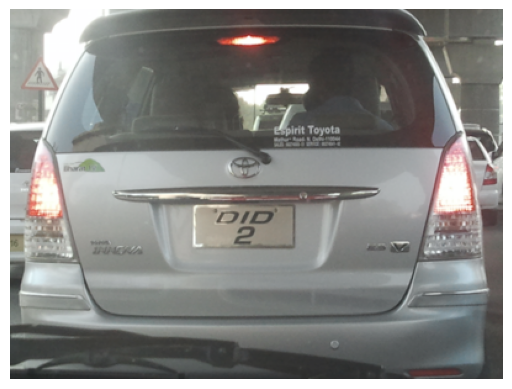

In [10]:
def img_check(image_path):
  img = cv2.imread(image_path)
  ##for mac there is issue with closing the window
  # cv2.namedWindow("sample_img", cv2.WINDOW_NORMAL)
  # cv2.imshow("sample_img",img)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  
img_check(df.iloc[0]["image_path"])

### 3. Create a bounding box for the first image

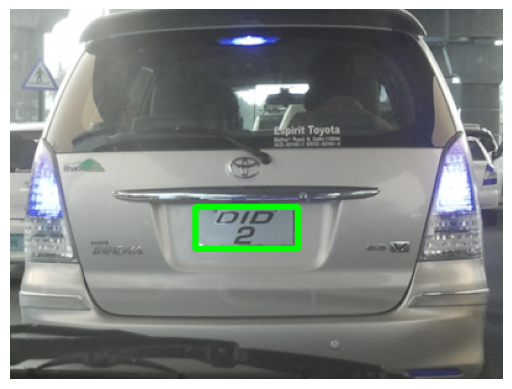

In [11]:
def create_bounding_box(image_path, xmin, xmax, ymin, ymax):
  img = cv2.imread(image_path)
  cv2.rectangle(img,(xmin,ymin), (xmax,ymax), (0,255,0), 3)
  plt.imshow(img)
  plt.axis("off")
  plt.show()
get_first_row=df.iloc[0,1:]
(xmin, xmax, ymin, ymax, image_path) = get_first_row
create_bounding_box(image_path,xmin,xmax, ymin, ymax)

### Data Pre-Processing

#### Normalization of the image

In [12]:
# %pip install scikit-learn tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
normalize_img_data = []
normalize_img_label_data = []
image_paths = df["image_path"]
for idx in range(len(image_paths)):
  img_path = image_paths[idx]
  img = cv2.imread(img_path)
  h,w,d = img.shape
  #pre-processing
  load_image = load_img(img_path,target_size=(224,224))
  img_array = img_to_array(load_image)
  
  #normalize image array
  norm_img_data = img_array / 255.0
  normalize_img_data.append(norm_img_data)
  
  #normalize label data
  labels = df.iloc[:,1:5].values
  xmin, xmax, ymin, ymax = labels[idx]
  nxmin, nxmax = xmin/w, xmax/w
  nymin, nymax = ymin/h, ymax/h
  normalize_label = (nxmin, nxmax, nymin, nymax)
  normalize_img_label_data.append(normalize_label)

## Convert to Numpy Array and split the train and test set

In [13]:
from sklearn.model_selection import train_test_split

##Images 
X = np.array(normalize_img_data,dtype=np.float32)
#Ouput Labels
Y =  np.array(normalize_img_label_data,dtype=np.float32)

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=1,train_size=0.8)
x_train.shape, y_train.shape, x_test.shape, y_test.shape 


((528, 224, 224, 3), (528, 4), (133, 224, 224, 3), (133, 4))

## Training the model

In [7]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [8]:
#Using Inception resnet mode
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
inception_model_input= inception_resnet.input
inception_model_output = inception_resnet.output
inception_model_output = Flatten()(inception_model_output)
inception_model_output = Dense(500,  activation="relu")(inception_model_output)
inception_model_output = Dense(250,  activation="relu")(inception_model_output)
inception_model_output = Dense(4, activation="sigmoid")(inception_model_output)

##Buld the model
model = Model(inputs=inception_model_input, outputs=inception_model_output)

## Compile the model

In [9]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 19,326,754 (73.73 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

## Training the model

In [18]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

tfb = TensorBoard("object_detection")

## Adding checkpoint
# directory to save best models
checkpoint = ModelCheckpoint(
    filepath="./checkpoints/model_epoch_{epoch:02d}.h5",  # save per epoch
    save_best_only=False,   # or True if you only want best val_loss
    save_weights_only=False,
    verbose=1
)

history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=100, validation_data=(x_test,y_test), callbacks=[tfb, checkpoint])

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 0.1431
Epoch 1: saving model to ./checkpoints/model_epoch_01.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 693ms/step - loss: 0.1430 - val_loss: 0.1264
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.1239
Epoch 2: saving model to ./checkpoints/model_epoch_02.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - loss: 0.1239 - val_loss: 0.1236
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 0.1169
Epoch 3: saving model to ./checkpoints/model_epoch_03.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 714ms/step - loss: 0.1169 - val_loss: 0.1206
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 0.1168
Epoch 4: saving model to ./checkpoints/model_epoch_04.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 686ms/step - loss: 0.1168 - val_loss: 0.1190
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.1146
Epoch 5: saving model to ./checkpoints/model_epoch_05.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 642ms/step - loss: 0.1147 - val_loss: 0.1187
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.1124
Epoch 6: saving model to ./checkpoints/model_epoch_06.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 622ms/step - loss: 0.1125 - val_loss: 0.1187
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.1134
Epoch 7: saving model to ./checkpoints/model_epoch_07.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - loss: 0.1134 - val_loss: 0.1185
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.1130
Epoch 8: saving model to ./checkpoints/model_epoch_08.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 0.1130 - val_loss: 0.1186
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.1113
Epoch 9: saving model to ./checkpoints/model_epoch_09.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 0.1112 - val_loss: 0.1286
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.0833
Epoch 10: saving model to ./checkpoints/model_epoch_10.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 627ms/step - loss: 0.0830 - val_loss: 0.0613
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0463
Epoch 11: saving model to ./checkpoints/model_epoch_11.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0371
Epoch 12: saving model to ./checkpoints/model_epoch_12.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 616ms/step - loss: 0.0371 - val_loss: 0.0434
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0334
Epoch 13: saving model to ./checkpoints/model_epoch_13.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 614ms/step - loss: 0.0333 - val_loss: 0.0433
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0317
Epoch 14: saving model to ./checkpoints/model_epoch_14.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - loss: 0.0317 - val_loss: 0.0433
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0321
Epoch 15: saving model to ./checkpoints/model_epoch_15.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 616ms/step - loss: 0.0320 - val_loss: 0.0435
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0311
Epoch 16: saving model to ./checkpoints/model_epoch_16.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - loss: 0.0311 - val_loss: 0.0429
Epoch 17/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0306
Epoch 17: saving model to ./checkpoints/model_epoch_17.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 0.0306 - val_loss: 0.0422
Epoch 18/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 0.0297
Epoch 18: saving model to ./checkpoints/model_epoch_18.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - loss: 0.0297 - val_loss: 0.0424
Epoch 19/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.0304
Epoch 19: saving model to ./checkpoints/model_epoch_19.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 652ms/step - loss: 0.0303 - val_loss: 0.0426
Epoch 20/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.0300
Epoch 20: saving model to ./checkpoints/model_epoch_20.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 631ms/step - loss: 0.0300 - val_loss: 0.0421
Epoch 21/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 0.0211
Epoch 21: saving model to ./checkpoints/model_epoch_21.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 625ms/step - loss: 0.0210 - val_loss: 0.0188
Epoch 22/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0075
Epoch 22: saving model to ./checkpoints/model_epoch_22.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 0.0075 - val_loss: 0.0152
Epoch 23/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 0.0036
Epoch 23: saving model to ./checkpoints/model_epoch_23.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 624ms/step - loss: 0.0036 - val_loss: 0.0136
Epoch 24/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0036
Epoch 24: saving model to ./checkpoints/model_epoch_24.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - loss: 0.0036 - val_loss: 0.0130
Epoch 25/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 0.0018
Epoch 25: saving model to ./checkpoints/model_epoch_25.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 622ms/step - loss: 0.0018 - val_loss: 0.0131
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0011
Epoch 26: saving model to ./checkpoints/model_epoch_26.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 616ms/step - loss: 0.0011 - val_loss: 0.0128
Epoch 27/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 8.2402e-04
Epoch 27: saving model to ./checkpoints/model_epoch_27.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 8.2228e-04 - val_loss: 0.0125
Epoch 28/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 6.5858e-04
Epoch 28: saving model to ./checkpoints/model_epoch_28.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 631ms/step - loss: 6.5884e-04 - val_loss: 0.0126
Epoch 29/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 6.2507e-04
Epoch 29: saving model to ./checkpoints/model_epoch_29.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 6.2531e-04 - val_loss: 0.0124
Epoch 30/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 3.5042e-04
Epoch 30: saving model to ./checkpoints/model_epoch_30.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - loss: 3.5099e-04 - val_loss: 0.0124
Epoch 31/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 3.5716e-04
Epoch 31: saving model to ./checkpoints/model_epoch_31.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 3.5744e-04 - val_loss: 0.0125
Epoch 32/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 6.3071e-04
Epoch 32: saving model to ./checkpoints/model_epoch_32.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 6.3139e-04 - val_loss: 0.0132
Epoch 33/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 7.7275e-04
Epoch 33: saving model to ./checkpoints/model_epoch_33.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 609ms/step - loss: 7.7249e-04 - val_loss: 0.0127
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 8.6583e-04
Epoch 34: saving model to ./checkpoints/model_epoch_34.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - loss: 8.6285e-04 - val_loss: 0.0126
Epoch 35/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 5.2318e-04
Epoch 35: saving model to ./checkpoints/model_epoch_35.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - loss: 5.2715e-04 - val_loss: 0.0141
Epoch 36/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.0011
Epoch 36: saving model to ./checkpoints/model_epoch_36.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 613ms/step - loss: 0.0011 - val_loss: 0.0133
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 9.1372e-04
Epoch 37: saving model to ./checkpoints/model_epoch_37.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 624ms/step - loss: 9.1208e-04 - val_loss: 0.0125
Epoch 38/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 6.5727e-04
Epoch 38: saving model to ./checkpoints/model_epoch_38.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 6.5721e-04 - val_loss: 0.0126
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 5.1211e-04
Epoch 39: saving model to ./checkpoints/model_epoch_39.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - loss: 5.1241e-04 - val_loss: 0.0126
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 4.5013e-04
Epoch 40: saving model to ./checkpoints/model_epoch_40.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 4.5127e-04 - val_loss: 0.0125
Epoch 41/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 4.4478e-04
Epoch 41: saving model to ./checkpoints/model_epoch_41.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - loss: 4.4545e-04 - val_loss: 0.0125
Epoch 42/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 5.4260e-04
Epoch 42: saving model to ./checkpoints/model_epoch_42.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 624ms/step - loss: 5.4257e-04 - val_loss: 0.0120
Epoch 43/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 6.2743e-04
Epoch 43: saving model to ./checkpoints/model_epoch_43.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - loss: 6.2719e-04 - val_loss: 0.0126
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 5.3505e-04
Epoch 44: saving model to ./checkpoints/model_epoch_44.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - loss: 5.3443e-04 - val_loss: 0.0125
Epoch 45/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 5.0090e-04
Epoch 45: saving model to ./checkpoints/model_epoch_45.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - loss: 5.0140e-04 - val_loss: 0.0126
Epoch 46/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 4.8860e-04
Epoch 46: saving model to ./checkpoints/model_epoch_46.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 634ms/step - loss: 4.9023e-04 - val_loss: 0.0125
Epoch 47/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 6.9054e-04
Epoch 47: saving model to ./checkpoints/model_epoch_47.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 659ms/step - loss: 6.9027e-04 - val_loss: 0.0128
Epoch 48/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 7.5419e-04
Epoch 48: saving model to ./checkpoints/model_epoch_48.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 661ms/step - loss: 7.5434e-04 - val_loss: 0.0126
Epoch 49/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 6.6754e-04
Epoch 49: saving model to ./checkpoints/model_epoch_49.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 664ms/step - loss: 6.7081e-04 - val_loss: 0.0123
Epoch 50/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 9.9746e-04
Epoch 50: saving model to ./checkpoints/model_epoch_50.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - loss: 9.9629e-04 - val_loss: 0.0124
Epoch 51/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 7.4009e-04
Epoch 51: saving model to ./checkpoints/model_epoch_51.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 629ms/step - loss: 7.4038e-04 - val_loss: 0.0123
Epoch 52/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 6.3747e-04
Epoch 52: saving model to ./checkpoints/model_epoch_52.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 6.4046e-04 - val_loss: 0.0128
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 9.3707e-04
Epoch 53: saving model to ./checkpoints/model_epoch_53.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - loss: 9.3736e-04 - val_loss: 0.0126
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 8.6690e-04
Epoch 54: saving model to ./checkpoints/model_epoch_54.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 8.6557e-04 - val_loss: 0.0125
Epoch 55/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 7.5193e-04
Epoch 55: saving model to ./checkpoints/model_epoch_55.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 626ms/step - loss: 7.5076e-04 - val_loss: 0.0122
Epoch 56/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 5.2012e-04
Epoch 56: saving model to ./checkpoints/model_epoch_56.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 5.2077e-04 - val_loss: 0.0123
Epoch 57/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 4.3830e-04
Epoch 57: saving model to ./checkpoints/model_epoch_57.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 4.3841e-04 - val_loss: 0.0122
Epoch 58/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 3.2749e-04
Epoch 58: saving model to ./checkpoints/model_epoch_58.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - loss: 3.2827e-04 - val_loss: 0.0123
Epoch 59/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 3.1818e-04
Epoch 59: saving model to ./checkpoints/model_epoch_59.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 613ms/step - loss: 3.1892e-04 - val_loss: 0.0121
Epoch 60/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 3.4026e-04
Epoch 60: saving model to ./checkpoints/model_epoch_60.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - loss: 3.4135e-04 - val_loss: 0.0122
Epoch 61/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 4.6817e-04
Epoch 61: saving model to ./checkpoints/model_epoch_61.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - loss: 4.6783e-04 - val_loss: 0.0124
Epoch 62/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 4.2053e-04
Epoch 62: saving model to ./checkpoints/model_epoch_62.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - loss: 4.2099e-04 - val_loss: 0.0122
Epoch 63/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 4.7317e-04
Epoch 63: saving model to ./checkpoints/model_epoch_63.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 621ms/step - loss: 4.7472e-04 - val_loss: 0.0120
Epoch 64/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 6.2405e-04
Epoch 64: saving model to ./checkpoints/model_epoch_64.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - loss: 6.2324e-04 - val_loss: 0.0124
Epoch 65/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 5.0160e-04
Epoch 65: saving model to ./checkpoints/model_epoch_65.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 5.0245e-04 - val_loss: 0.0126
Epoch 66/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 5.2365e-04
Epoch 66: saving model to ./checkpoints/model_epoch_66.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - loss: 5.2490e-04 - val_loss: 0.0126
Epoch 67/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 5.8919e-04
Epoch 67: saving model to ./checkpoints/model_epoch_67.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - loss: 5.8806e-04 - val_loss: 0.0121
Epoch 68/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 4.8388e-04
Epoch 68: saving model to ./checkpoints/model_epoch_68.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - loss: 4.8403e-04 - val_loss: 0.0126
Epoch 69/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 6.1873e-04
Epoch 69: saving model to ./checkpoints/model_epoch_69.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - loss: 6.1793e-04 - val_loss: 0.0124
Epoch 70/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 7.0231e-04
Epoch 70: saving model to ./checkpoints/model_epoch_70.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 652ms/step - loss: 7.0045e-04 - val_loss: 0.0124
Epoch 71/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 5.0227e-04
Epoch 71: saving model to ./checkpoints/model_epoch_71.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 731ms/step - loss: 5.0190e-04 - val_loss: 0.0124
Epoch 72/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 4.0429e-04
Epoch 72: saving model to ./checkpoints/model_epoch_72.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - loss: 4.0476e-04 - val_loss: 0.0119
Epoch 73/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 4.7119e-04
Epoch 73: saving model to ./checkpoints/model_epoch_73.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 701ms/step - loss: 4.7083e-04 - val_loss: 0.0121
Epoch 74/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 5.2644e-04
Epoch 74: saving model to ./checkpoints/model_epoch_74.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - loss: 5.2648e-04 - val_loss: 0.0121
Epoch 75/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 4.4473e-04
Epoch 75: saving model to ./checkpoints/model_epoch_75.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 705ms/step - loss: 4.4727e-04 - val_loss: 0.0123
Epoch 76/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 7.2986e-04
Epoch 76: saving model to ./checkpoints/model_epoch_76.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 709ms/step - loss: 7.2923e-04 - val_loss: 0.0127
Epoch 77/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 6.4939e-04
Epoch 77: saving model to ./checkpoints/model_epoch_77.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - loss: 6.4993e-04 - val_loss: 0.0118
Epoch 78/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 5.6528e-04
Epoch 78: saving model to ./checkpoints/model_epoch_78.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 673ms/step - loss: 5.6483e-04 - val_loss: 0.0123
Epoch 79/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 5.5446e-04
Epoch 79: saving model to ./checkpoints/model_epoch_79.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 667ms/step - loss: 5.5481e-04 - val_loss: 0.0118
Epoch 80/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 5.1451e-04
Epoch 80: saving model to ./checkpoints/model_epoch_80.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 667ms/step - loss: 5.1698e-04 - val_loss: 0.0124
Epoch 81/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 7.6398e-04
Epoch 81: saving model to ./checkpoints/model_epoch_81.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 664ms/step - loss: 7.6631e-04 - val_loss: 0.0120
Epoch 82/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 6.8006e-04
Epoch 82: saving model to ./checkpoints/model_epoch_82.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 658ms/step - loss: 6.8158e-04 - val_loss: 0.0126
Epoch 83/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 7.1391e-04
Epoch 83: saving model to ./checkpoints/model_epoch_83.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - loss: 7.1306e-04 - val_loss: 0.0120
Epoch 84/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 5.9037e-04
Epoch 84: saving model to ./checkpoints/model_epoch_84.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 650ms/step - loss: 5.8976e-04 - val_loss: 0.0122
Epoch 85/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 7.3568e-04
Epoch 85: saving model to ./checkpoints/model_epoch_85.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 672ms/step - loss: 7.3310e-04 - val_loss: 0.0120
Epoch 86/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 4.7403e-04
Epoch 86: saving model to ./checkpoints/model_epoch_86.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 666ms/step - loss: 4.7448e-04 - val_loss: 0.0119
Epoch 87/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 5.1880e-04
Epoch 87: saving model to ./checkpoints/model_epoch_87.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 671ms/step - loss: 5.1855e-04 - val_loss: 0.0118
Epoch 88/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 4.2317e-04
Epoch 88: saving model to ./checkpoints/model_epoch_88.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 661ms/step - loss: 4.2271e-04 - val_loss: 0.0121
Epoch 89/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 3.5770e-04
Epoch 89: saving model to ./checkpoints/model_epoch_89.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - loss: 3.5801e-04 - val_loss: 0.0119
Epoch 90/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 3.2962e-04
Epoch 90: saving model to ./checkpoints/model_epoch_90.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - loss: 3.3018e-04 - val_loss: 0.0119
Epoch 91/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 3.5949e-04
Epoch 91: saving model to ./checkpoints/model_epoch_91.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - loss: 3.5985e-04 - val_loss: 0.0120
Epoch 92/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 3.1498e-04
Epoch 92: saving model to ./checkpoints/model_epoch_92.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 662ms/step - loss: 3.1497e-04 - val_loss: 0.0120
Epoch 93/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 3.5530e-04
Epoch 93: saving model to ./checkpoints/model_epoch_93.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 658ms/step - loss: 3.5476e-04 - val_loss: 0.0119
Epoch 94/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 2.7630e-04
Epoch 94: saving model to ./checkpoints/model_epoch_94.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - loss: 2.7604e-04 - val_loss: 0.0119
Epoch 95/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - loss: 2.7474e-04
Epoch 95: saving model to ./checkpoints/model_epoch_95.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 798ms/step - loss: 2.7469e-04 - val_loss: 0.0114
Epoch 96/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 2.5386e-04
Epoch 96: saving model to ./checkpoints/model_epoch_96.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 669ms/step - loss: 2.5409e-04 - val_loss: 0.0120
Epoch 97/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 2.4948e-04
Epoch 97: saving model to ./checkpoints/model_epoch_97.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 695ms/step - loss: 2.4993e-04 - val_loss: 0.0120
Epoch 98/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - loss: 3.2356e-04
Epoch 98: saving model to ./checkpoints/model_epoch_98.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 754ms/step - loss: 3.2371e-04 - val_loss: 0.0123
Epoch 99/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 5.3632e-04
Epoch 99: saving model to ./checkpoints/model_epoch_99.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - loss: 5.3611e-04 - val_loss: 0.0120
Epoch 100/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 4.6873e-04
Epoch 100: saving model to ./checkpoints/model_epoch_100.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 698ms/step - loss: 4.6967e-04 - val_loss: 0.0119


In [22]:
from keras.utils import custom_object_scope

# Example custom layer
class CustomScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return inputs * 0.5 

In [26]:
## if we need to continue the training with more epoch and continue from where it left we can do as below
from tensorflow.keras.models import load_model

# Load last saved model
model.load_weights("./checkpoints/model_epoch_100.h5")
history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=200, validation_data=(x_test,y_test), callbacks=[tfb, checkpoint], initial_epoch=100)

Epoch 101/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 8.2288e-04
Epoch 101: saving model to ./checkpoints/model_epoch_101.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 609ms/step - loss: 8.2018e-04 - val_loss: 0.0119
Epoch 102/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 3.9728e-04
Epoch 102: saving model to ./checkpoints/model_epoch_102.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 634ms/step - loss: 3.9816e-04 - val_loss: 0.0117
Epoch 103/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 4.2834e-04
Epoch 103: saving model to ./checkpoints/model_epoch_103.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 691ms/step - loss: 4.2891e-04 - val_loss: 0.0120
Epoch 104/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 5.3190e-04
Epoch 104: saving model to ./checkpoints/model_epoch_104.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - loss: 5.3200e-04 - val_loss: 0.0119
Epoch 105/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 5.1688e-04
Epoch 105: saving model to ./checkpoints/model_epoch_105.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - loss: 5.1671e-04 - val_loss: 0.0119
Epoch 106/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 5.5840e-04
Epoch 106: saving model to ./checkpoints/model_epoch_106.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - loss: 5.5769e-04 - val_loss: 0.0120
Epoch 107/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.8716e-04
Epoch 107: saving model to ./checkpoints/model_epoch_107.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - loss: 3.8870e-04 - val_loss: 0.0119
Epoch 108/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 5.7394e-04
Epoch 108: saving model to ./checkpoints/model_epoch_108.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - loss: 5.7320e-04 - val_loss: 0.0123
Epoch 109/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 4.3055e-04
Epoch 109: saving model to ./checkpoints/model_epoch_109.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 643ms/step - loss: 4.3099e-04 - val_loss: 0.0121
Epoch 110/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 4.4046e-04
Epoch 110: saving model to ./checkpoints/model_epoch_110.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 587ms/step - loss: 4.4060e-04 - val_loss: 0.0119
Epoch 111/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 3.5956e-04
Epoch 111: saving model to ./checkpoints/model_epoch_111.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 591ms/step - loss: 3.5940e-04 - val_loss: 0.0122
Epoch 112/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 4.0790e-04
Epoch 112: saving model to ./checkpoints/model_epoch_112.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 589ms/step - loss: 4.0745e-04 - val_loss: 0.0116
Epoch 113/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 3.8468e-04
Epoch 113: saving model to ./checkpoints/model_epoch_113.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 588ms/step - loss: 3.8477e-04 - val_loss: 0.0117
Epoch 114/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.9739e-04
Epoch 114: saving model to ./checkpoints/model_epoch_114.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - loss: 3.9758e-04 - val_loss: 0.0119
Epoch 115/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 3.3493e-04
Epoch 115: saving model to ./checkpoints/model_epoch_115.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 641ms/step - loss: 3.3492e-04 - val_loss: 0.0117
Epoch 116/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 3.1184e-04
Epoch 116: saving model to ./checkpoints/model_epoch_116.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - loss: 3.1184e-04 - val_loss: 0.0120
Epoch 117/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 4.5832e-04
Epoch 117: saving model to ./checkpoints/model_epoch_117.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - loss: 4.5774e-04 - val_loss: 0.0120
Epoch 118/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 3.7487e-04
Epoch 118: saving model to ./checkpoints/model_epoch_118.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - loss: 3.7519e-04 - val_loss: 0.0119
Epoch 119/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 4.4548e-04
Epoch 119: saving model to ./checkpoints/model_epoch_119.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - loss: 4.4543e-04 - val_loss: 0.0119
Epoch 120/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 4.2121e-04
Epoch 120: saving model to ./checkpoints/model_epoch_120.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - loss: 4.2246e-04 - val_loss: 0.0120
Epoch 121/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 4.2695e-04
Epoch 121: saving model to ./checkpoints/model_epoch_121.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - loss: 4.2718e-04 - val_loss: 0.0117
Epoch 122/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 3.8867e-04
Epoch 122: saving model to ./checkpoints/model_epoch_122.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - loss: 3.8820e-04 - val_loss: 0.0121
Epoch 123/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 3.2912e-04
Epoch 123: saving model to ./checkpoints/model_epoch_123.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - loss: 3.2890e-04 - val_loss: 0.0117
Epoch 124/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 3.4780e-04
Epoch 124: saving model to ./checkpoints/model_epoch_124.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 665ms/step - loss: 3.4819e-04 - val_loss: 0.0117
Epoch 125/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 3.5427e-04
Epoch 125: saving model to ./checkpoints/model_epoch_125.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 618ms/step - loss: 3.5373e-04 - val_loss: 0.0117
Epoch 126/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 2.4927e-04
Epoch 126: saving model to ./checkpoints/model_epoch_126.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 651ms/step - loss: 2.4936e-04 - val_loss: 0.0119
Epoch 127/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 2.9273e-04
Epoch 127: saving model to ./checkpoints/model_epoch_127.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - loss: 2.9278e-04 - val_loss: 0.0117
Epoch 128/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 2.5728e-04
Epoch 128: saving model to ./checkpoints/model_epoch_128.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - loss: 2.5732e-04 - val_loss: 0.0122
Epoch 129/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 2.4755e-04
Epoch 129: saving model to ./checkpoints/model_epoch_129.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - loss: 2.4770e-04 - val_loss: 0.0120
Epoch 130/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 2.2013e-04
Epoch 130: saving model to ./checkpoints/model_epoch_130.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - loss: 2.2031e-04 - val_loss: 0.0120
Epoch 131/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 2.5563e-04
Epoch 131: saving model to ./checkpoints/model_epoch_131.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - loss: 2.5596e-04 - val_loss: 0.0121
Epoch 132/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 3.2294e-04
Epoch 132: saving model to ./checkpoints/model_epoch_132.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - loss: 3.2283e-04 - val_loss: 0.0115
Epoch 133/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 2.7936e-04
Epoch 133: saving model to ./checkpoints/model_epoch_133.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - loss: 2.8073e-04 - val_loss: 0.0120
Epoch 134/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 3.3373e-04
Epoch 134: saving model to ./checkpoints/model_epoch_134.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 643ms/step - loss: 3.3359e-04 - val_loss: 0.0118
Epoch 135/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 2.6703e-04
Epoch 135: saving model to ./checkpoints/model_epoch_135.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - loss: 2.6796e-04 - val_loss: 0.0120
Epoch 136/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 4.1912e-04
Epoch 136: saving model to ./checkpoints/model_epoch_136.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 790ms/step - loss: 4.1857e-04 - val_loss: 0.0114
Epoch 137/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 3.8764e-04
Epoch 137: saving model to ./checkpoints/model_epoch_137.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 746ms/step - loss: 3.8816e-04 - val_loss: 0.0116
Epoch 138/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - loss: 4.7464e-04
Epoch 138: saving model to ./checkpoints/model_epoch_138.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 693ms/step - loss: 4.7515e-04 - val_loss: 0.0115
Epoch 139/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 4.7910e-04
Epoch 139: saving model to ./checkpoints/model_epoch_139.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - loss: 4.7948e-04 - val_loss: 0.0118
Epoch 140/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 5.2338e-04
Epoch 140: saving model to ./checkpoints/model_epoch_140.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 5.2238e-04 - val_loss: 0.0121
Epoch 141/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 4.7965e-04
Epoch 141: saving model to ./checkpoints/model_epoch_141.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - loss: 4.7981e-04 - val_loss: 0.0121
Epoch 142/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 3.8876e-04
Epoch 142: saving model to ./checkpoints/model_epoch_142.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 660ms/step - loss: 3.8860e-04 - val_loss: 0.0120
Epoch 143/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 3.3572e-04
Epoch 143: saving model to ./checkpoints/model_epoch_143.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - loss: 3.3505e-04 - val_loss: 0.0118
Epoch 144/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 2.3293e-04
Epoch 144: saving model to ./checkpoints/model_epoch_144.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 765ms/step - loss: 2.3371e-04 - val_loss: 0.0120
Epoch 145/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 2.3081e-04
Epoch 145: saving model to ./checkpoints/model_epoch_145.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - loss: 2.3087e-04 - val_loss: 0.0117
Epoch 146/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - loss: 2.5617e-04
Epoch 146: saving model to ./checkpoints/model_epoch_146.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - loss: 2.5634e-04 - val_loss: 0.0118
Epoch 147/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - loss: 2.8957e-04
Epoch 147: saving model to ./checkpoints/model_epoch_147.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 828ms/step - loss: 2.8919e-04 - val_loss: 0.0118
Epoch 148/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 3.1568e-04
Epoch 148: saving model to ./checkpoints/model_epoch_148.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 654ms/step - loss: 3.1701e-04 - val_loss: 0.0121
Epoch 149/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 4.1545e-04
Epoch 149: saving model to ./checkpoints/model_epoch_149.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 656ms/step - loss: 4.1570e-04 - val_loss: 0.0122
Epoch 150/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 4.5693e-04
Epoch 150: saving model to ./checkpoints/model_epoch_150.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - loss: 4.5699e-04 - val_loss: 0.0116
Epoch 151/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 3.5032e-04
Epoch 151: saving model to ./checkpoints/model_epoch_151.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - loss: 3.5093e-04 - val_loss: 0.0120
Epoch 152/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 4.0159e-04
Epoch 152: saving model to ./checkpoints/model_epoch_152.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 695ms/step - loss: 4.0153e-04 - val_loss: 0.0119
Epoch 153/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 4.0378e-04
Epoch 153: saving model to ./checkpoints/model_epoch_153.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 689ms/step - loss: 4.0269e-04 - val_loss: 0.0117
Epoch 154/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 3.2168e-04
Epoch 154: saving model to ./checkpoints/model_epoch_154.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 635ms/step - loss: 3.2303e-04 - val_loss: 0.0119
Epoch 155/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 3.2102e-04
Epoch 155: saving model to ./checkpoints/model_epoch_155.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 634ms/step - loss: 3.2094e-04 - val_loss: 0.0118
Epoch 156/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 2.4934e-04
Epoch 156: saving model to ./checkpoints/model_epoch_156.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 727ms/step - loss: 2.4940e-04 - val_loss: 0.0118
Epoch 157/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 2.8294e-04
Epoch 157: saving model to ./checkpoints/model_epoch_157.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - loss: 2.8288e-04 - val_loss: 0.0118
Epoch 158/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 2.0928e-04
Epoch 158: saving model to ./checkpoints/model_epoch_158.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - loss: 2.0951e-04 - val_loss: 0.0119
Epoch 159/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 2.0566e-04
Epoch 159: saving model to ./checkpoints/model_epoch_159.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - loss: 2.0625e-04 - val_loss: 0.0116
Epoch 160/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 2.0603e-04
Epoch 160: saving model to ./checkpoints/model_epoch_160.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - loss: 2.0631e-04 - val_loss: 0.0118
Epoch 161/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 2.6949e-04
Epoch 161: saving model to ./checkpoints/model_epoch_161.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 605ms/step - loss: 2.6931e-04 - val_loss: 0.0118
Epoch 162/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 2.4831e-04
Epoch 162: saving model to ./checkpoints/model_epoch_162.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 616ms/step - loss: 2.4853e-04 - val_loss: 0.0120
Epoch 163/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 2.9295e-04
Epoch 163: saving model to ./checkpoints/model_epoch_163.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - loss: 2.9247e-04 - val_loss: 0.0116
Epoch 164/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 2.8876e-04
Epoch 164: saving model to ./checkpoints/model_epoch_164.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - loss: 2.8845e-04 - val_loss: 0.0116
Epoch 165/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 2.8133e-04
Epoch 165: saving model to ./checkpoints/model_epoch_165.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - loss: 2.8139e-04 - val_loss: 0.0118
Epoch 166/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 3.0791e-04
Epoch 166: saving model to ./checkpoints/model_epoch_166.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - loss: 3.0755e-04 - val_loss: 0.0117
Epoch 167/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 3.8076e-04
Epoch 167: saving model to ./checkpoints/model_epoch_167.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 636ms/step - loss: 3.8020e-04 - val_loss: 0.0117
Epoch 168/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 3.1088e-04
Epoch 168: saving model to ./checkpoints/model_epoch_168.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - loss: 3.1112e-04 - val_loss: 0.0118
Epoch 169/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 3.0250e-04
Epoch 169: saving model to ./checkpoints/model_epoch_169.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - loss: 3.0300e-04 - val_loss: 0.0118
Epoch 170/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 3.6115e-04
Epoch 170: saving model to ./checkpoints/model_epoch_170.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - loss: 3.6081e-04 - val_loss: 0.0118
Epoch 171/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 2.6208e-04
Epoch 171: saving model to ./checkpoints/model_epoch_171.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - loss: 2.6325e-04 - val_loss: 0.0118
Epoch 172/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 3.8039e-04
Epoch 172: saving model to ./checkpoints/model_epoch_172.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - loss: 3.8074e-04 - val_loss: 0.0117
Epoch 173/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 3.4292e-04
Epoch 173: saving model to ./checkpoints/model_epoch_173.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 701ms/step - loss: 3.4367e-04 - val_loss: 0.0120
Epoch 174/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 4.1791e-04
Epoch 174: saving model to ./checkpoints/model_epoch_174.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 706ms/step - loss: 4.1799e-04 - val_loss: 0.0117
Epoch 175/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - loss: 3.9940e-04
Epoch 175: saving model to ./checkpoints/model_epoch_175.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 743ms/step - loss: 3.9948e-04 - val_loss: 0.0118
Epoch 176/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 4.1720e-04
Epoch 176: saving model to ./checkpoints/model_epoch_176.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 649ms/step - loss: 4.1666e-04 - val_loss: 0.0119
Epoch 177/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 3.4189e-04
Epoch 177: saving model to ./checkpoints/model_epoch_177.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 710ms/step - loss: 3.4235e-04 - val_loss: 0.0117
Epoch 178/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 3.2347e-04
Epoch 178: saving model to ./checkpoints/model_epoch_178.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - loss: 3.2353e-04 - val_loss: 0.0123
Epoch 179/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 3.4928e-04
Epoch 179: saving model to ./checkpoints/model_epoch_179.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 694ms/step - loss: 3.5018e-04 - val_loss: 0.0117
Epoch 180/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 4.0084e-04
Epoch 180: saving model to ./checkpoints/model_epoch_180.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 703ms/step - loss: 4.0002e-04 - val_loss: 0.0121
Epoch 181/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 3.0083e-04
Epoch 181: saving model to ./checkpoints/model_epoch_181.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 680ms/step - loss: 3.0050e-04 - val_loss: 0.0117
Epoch 182/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 2.4232e-04
Epoch 182: saving model to ./checkpoints/model_epoch_182.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - loss: 2.4280e-04 - val_loss: 0.0117
Epoch 183/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 2.9785e-04
Epoch 183: saving model to ./checkpoints/model_epoch_183.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step - loss: 2.9786e-04 - val_loss: 0.0117
Epoch 184/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 2.4143e-04
Epoch 184: saving model to ./checkpoints/model_epoch_184.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - loss: 2.4197e-04 - val_loss: 0.0115
Epoch 185/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - loss: 2.6992e-04
Epoch 185: saving model to ./checkpoints/model_epoch_185.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 767ms/step - loss: 2.7015e-04 - val_loss: 0.0115
Epoch 186/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 2.5400e-04
Epoch 186: saving model to ./checkpoints/model_epoch_186.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 662ms/step - loss: 2.5433e-04 - val_loss: 0.0116
Epoch 187/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 2.9885e-04
Epoch 187: saving model to ./checkpoints/model_epoch_187.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - loss: 2.9848e-04 - val_loss: 0.0116
Epoch 188/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 2.5532e-04
Epoch 188: saving model to ./checkpoints/model_epoch_188.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 640ms/step - loss: 2.5512e-04 - val_loss: 0.0120
Epoch 189/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - loss: 2.7073e-04
Epoch 189: saving model to ./checkpoints/model_epoch_189.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 643ms/step - loss: 2.7146e-04 - val_loss: 0.0115
Epoch 190/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 2.7312e-04
Epoch 190: saving model to ./checkpoints/model_epoch_190.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 607ms/step - loss: 2.7311e-04 - val_loss: 0.0116
Epoch 191/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 2.3365e-04
Epoch 191: saving model to ./checkpoints/model_epoch_191.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - loss: 2.3363e-04 - val_loss: 0.0117
Epoch 192/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.2503e-04
Epoch 192: saving model to ./checkpoints/model_epoch_192.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - loss: 2.2561e-04 - val_loss: 0.0117
Epoch 193/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 2.6328e-04
Epoch 193: saving model to ./checkpoints/model_epoch_193.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - loss: 2.6324e-04 - val_loss: 0.0118
Epoch 194/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 3.2665e-04
Epoch 194: saving model to ./checkpoints/model_epoch_194.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - loss: 3.2593e-04 - val_loss: 0.0116
Epoch 195/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 2.2602e-04
Epoch 195: saving model to ./checkpoints/model_epoch_195.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 558ms/step - loss: 2.2639e-04 - val_loss: 0.0118
Epoch 196/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 2.4304e-04
Epoch 196: saving model to ./checkpoints/model_epoch_196.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - loss: 2.4344e-04 - val_loss: 0.0116
Epoch 197/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 2.7802e-04
Epoch 197: saving model to ./checkpoints/model_epoch_197.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 558ms/step - loss: 2.7799e-04 - val_loss: 0.0116
Epoch 198/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 2.6414e-04
Epoch 198: saving model to ./checkpoints/model_epoch_198.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - loss: 2.6483e-04 - val_loss: 0.0117
Epoch 199/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 3.4899e-04
Epoch 199: saving model to ./checkpoints/model_epoch_199.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - loss: 3.4822e-04 - val_loss: 0.0116
Epoch 200/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 2.3259e-04
Epoch 200: saving model to ./checkpoints/model_epoch_200.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 544ms/step - loss: 2.3298e-04 - val_loss: 0.0115


## Saving  the model

In [54]:
model.save("./model/object_detection.keras")

## Tensorboard

In [11]:
## In order to open the model in tenorboard, we need to got the the project folder.
## once we run the above training, a folder named "object_detection" will be created
## we need to cd to the root folder and run the below command:
## tensorboard --logdir="object_detection"

## Making prediction with the saved model

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [17]:
# For .h5 or .keras
import keras
model2 = keras.models.load_model("./model/object_detection.keras")
print("loaded model")

loaded model


Height of the image : 268
Width of the image : 500
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(np.int32(238), np.int32(125)) (np.int32(416), np.int32(167))


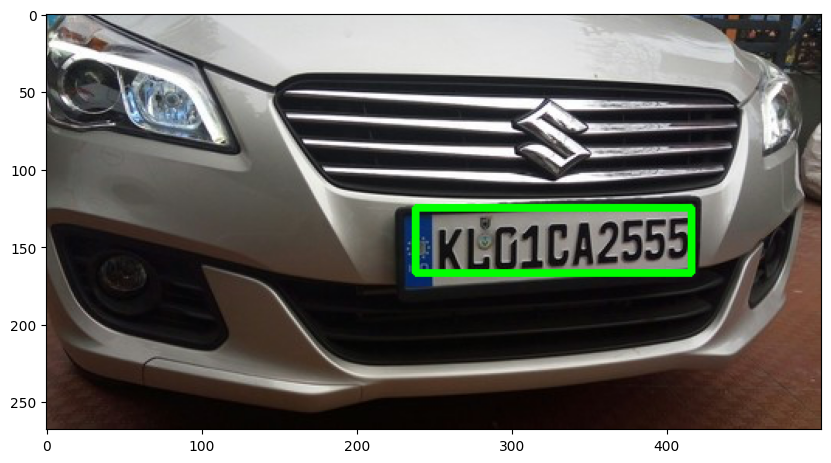

In [ ]:
import numpy as np
def object_detection_pipeline(test_image_path):
  image = load_img(test_image_path) #PIL object
  image = np.array(image, dtype=np.uint8) # 8-bit array (0,255)
  image1 = load_img(test_image_path, target_size=(224,224))
  
  #Pre-processing of the image
  image1_arr_224  = img_to_array(image1)/255.0 # convert the image to array and get the normalized output
  h,w,d = image.shape
  print(f"Height of the image : {h}")
  print(f"Width of the image : {w}")
  print(image1_arr_224.shape)
  #Modify the normalize image to have four dimension
  test_arr = image1_arr_224.reshape(1, 224, 224, 3)
  
  #Making prediction
  co_ordinates = model2.predict(test_arr)
  ##Denormalize the co ordinats
  denormalize = np.array([w,w,h,h])
  denormalize_co_ordinates = co_ordinates * denormalize
  denormalize_co_ordinates = denormalize_co_ordinates.astype(np.int32)
  denormalize_co_ordinates
  
  #Create bounding box over the image
  xmin, xmax, ymin, ymax = denormalize_co_ordinates[0]
  point1 = (xmin,ymin)
  point2 = (xmax,ymax)
  print(point1, point2)
  cv2.rectangle(image, point1, point2, (0,255,0),3)
  return image, denormalize_co_ordinates

test_image_path = "../test_images/Cars0.png"
image, co_ordinate = object_detection_pipeline(test_image_path)
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

## OCR- Extract text from the bounding box

### Getting the region of interest based on the co-ordinate

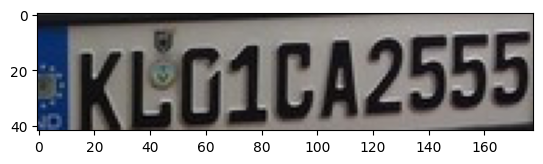

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
## Load the original images
img = np.array(load_img(test_image_path))
xmin, xmax, ymin, ymax = co_ordinate[0]
region_of_interest = img[ymin:ymax, xmin:xmax]

plt.imshow(region_of_interest)
plt.show()

### Using pytesseract to extract the text from image

In [ ]:
%pip install pytesseract
import pytesseract as pt
pt.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract' 
pt.image_to_string(region_of_interest)


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/bin/bash: tesseract: command not found


'AK IG10A2559\n'

### Using easyOCR to extract the text from image

In [21]:
%pip install easyocr
import easyocr

reader = easyocr.Reader(['en'])
results = reader.readtext(region_of_interest)
for (bbox, text, prob) in results:
  print(f"Detected: {text} (Confidence: {prob:.2f})")

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached torch-2.8.0-cp311-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached shapely-2.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached pyclipper-1.3.0.post6-cp311-cp311-macosx_10_9_universal2.whl.metadata (9.0 kB)
  Using cached ninja-1.13.0-py3-none-macosx_10_9_universal2.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached torchvision-0.23.0-cp311-cp311-macosx_11_0_arm64.whl (1.9 MB)
Using cached torch-2.8.0-cp311-none-macosx_11_0_arm64.whl (73.6 MB)
Using cached ninja-1.13.0-py3-none-macosx_10_9_universal2.whl (310 kB)
Using cached pyclipper-1.3.0.post6-cp311-cp311-macosx_10_9_universal2.whl (270 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/Users/anuborah@sphnet.com.sg/IdeaProjects/car_number_plate_detection/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Detected: KLG1CA2555 (Confidence: 0.54)


### Extract text using LLM model

#### 1. Using common code below to extract text using models existing in github marketplace.

In [43]:
# %pip install openai
import os
import cv2
import base64
from openai import OpenAI
import re

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv
    load_dotenv(override=True)
except ImportError:
    pass

# Convert ROI (NumPy array) to base64
_, buffer = cv2.imencode(".jpg", region_of_interest)
img_base64 = base64.b64encode(buffer).decode("utf-8")
img_data_uri = f"data:image/jpeg;base64,{img_base64}"

# Init GitHub Models client
client = OpenAI(
    base_url="https://models.inference.ai.azure.com",
    api_key=os.getenv("GITHUB_TOKEN"),
)

def extract_result_from_message_prompt(raw_text):
  match = re.search(r"\*\*(.*?)\*\*", raw_text)
  if match:
      extracted_text = match.group(1).strip()
  else:
      # fallback: just strip everything after colon
      extracted_text = raw_text.split(":")[-1].strip()
  return extracted_text

def extract_text_from_image(model_name):
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Please extract all readable text from this image region."},
                    {"type": "image_url", "image_url": {"url": img_data_uri}},
                ],
            }
        ],
        max_tokens=500,
    )
    return response.choices[0].message.content

#### 2. Using GPT LLM Multi Modal to extract the text from image

In [63]:
# Run with GPT-4.1-mini
gpt_4_1_mini_text = extract_text_from_image("gpt-4.1-mini")
get_gpt_4_1_mini_number_plate_no = extract_result_from_message_prompt(gpt_4_1_mini_text)
print("Get number plate using gpt-4.1-mini :", get_gpt_4_1_mini_number_plate_no)

#Run with GPT-4.1-nano
gpt_4_1_nano_text = extract_text_from_image("gpt-4.1-nano")
get_gpt_4_1_nano_number_plate_no = extract_result_from_message_prompt(gpt_4_1_nano_text)
print("Get number plate using gpt-4.1-nano :", get_gpt_4_1_nano_number_plate_no)

#Run with GPT-4o-mini
gpt_4o_mini_text = extract_text_from_image("gpt-4o-mini")
get_gpt_4o_mini_number_plate_no = extract_result_from_message_prompt(gpt_4o_mini_text)
print("Get number plate using gpt-4o-mini :", get_gpt_4o_mini_number_plate_no)

Get number plate using gpt-4.1-mini : K L 01CA2555
Get number plate using gpt-4.1-nano : "KL01CA2555"
Get number plate using gpt-4o-mini : KL01CA2555


#### Using Mistral Small LLM Multi Modal to extract the image

In [58]:
mistral_small_text = extract_text_from_image("mistral-small-2503")
get_mistral_small_number_plate_no = extract_result_from_message_prompt(mistral_small_text)
print("Get number plate using Mistral Small LLM :", get_mistral_small_number_plate_no)

Get number plate using Mistral Small LLM : KLG01CA2555


#### Using Phi-4-multimodal-instruct to extract the image

In [60]:
phi_4_multimodal_small_text = extract_text_from_image("Phi-4-multimodal-instruct")
get_phi_4_multimodal_number_plate_no = extract_result_from_message_prompt(phi_4_multimodal_small_text)
print("Get number plate using Phi-4-multimodal-instruct :", get_phi_4_multimodal_number_plate_no)

Get number plate using Phi-4-multimodal-instruct : KLO1CA2555


In [52]:
# %pip install anthropic python-dotenv
# import os
# import base64
# import cv2
# from anthropic import Anthropic

# try:
#     # load environment variables from .env file (requires `python-dotenv`)
#     from dotenv import load_dotenv
#     load_dotenv(override=True)
# except ImportError:
#     pass

# # Assuming `region_of_interest` is a NumPy image (your cropped ROI)
# # Convert ROI to JPEG in memory
# _, buffer = cv2.imencode(".jpg", region_of_interest)
# img_base64 = base64.b64encode(buffer).decode("utf-8")


# # Init Claude client
# client = Anthropic(api_key=os.getenv("ANTHOPIC_API_KEY"))

# # Send to Claude with multimodal prompt
# resp = client.messages.create(
#     model="claude-3.5-sonnet",  # Claude model that supports vision
#     max_tokens=500,
#     messages=[
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "image",
#                     "source": {
#                         "type": "base64",
#                         "media_type": "image/jpeg",
#                         "data": img_base64,
#                     },
#                 },
#                 {
#                     "type": "text",
#                     "text": "Please extract and return all readable text from this image region.",
#                 },
#             ],
#         }
#     ],
# )

# # Extract Claude’s text output
# print("Claude OCR Result:", resp.content[0].text)